In [0]:
!unzip homework3.zip

In [0]:
#from __future__ import absolute_import, division, print_function
import numpy as np 
import pandas as pd
import tensorflow as tf
import librosa
import os
import pickle
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Reshape

### Function to perform Sequence Length Padding
In this project, we are loading audio files of varying lengths. </br>
The Sequence Padding function is used to maintain uniformity in the dimension of data that is passed to neural network training.</br>
***max_seq_length*** would ideally be the length of the longest audio file in the dataset

In [0]:
def sequence_padding(audio_matrix_collection,max_seq_length=300):
  Padded_Matrix=[]
  for i in range(len(audio_matrix_collection)): #For each audio file
    Padded_Matrix.append(np.pad(audio_matrix_collection[i], ((0,max_seq_length-audio_matrix_collection[i].shape[0]),(0,0)), 'constant'))
  return Padded_Matrix

### Function for creating Ideal Binary Masks
Which is the expected mask matrix output from the neural network

In [0]:
def create_IBM(Speech,Noise,max_seq_length=300):
  IBM=[]
  for i in range(len(Speech)):
    IBM.append(1*(Speech[i]>Noise[i]))
  return sequence_padding(IBM,max_seq_length)

### Funtion for random shuffling of data used for minibatching

In [0]:
def random_shuffling(X,Noise,Seq):
    random = np.arange(0, len(X))
    np.random.shuffle(random)
    A=[X[i] for i in random]
    B=[Noise[i] for i in random]
    C=[Seq[i] for i in random]
    
    return A,B,C

### Gathering the list of files in the Training, Validation and Test sets

In [0]:
Train_Files, Val_Files, Test_Files = [[] for i in range(3)]
Train_Files = os.listdir('timit-homework/tr')
Val_Files = os.listdir('timit-homework/v')
Test_Files = os.listdir('timit-homework/te')
Train_Files.sort()
Val_Files.sort()
Test_Files.sort()

### Reading Training and Validation Data

*   The first 1200 files are the Noise parts of the audio
*   The second 1200 files are the Clean speech files
*   The last 1200 files are the noisy speech files that will be used for training




In [0]:
Train_Noise,Train_Clean,Train_Mixed,Train_Audio_Len=[[] for i in range(4)]
for i in range(1200):
    s, sr=librosa.load('timit-homework/tr/' + Train_Files[i], sr=None)
    Train_Noise.append(np.transpose(np.abs(librosa.stft(s, n_fft=1024, hop_length=512))))

    s, sr=librosa.load('timit-homework/tr/' + Train_Files[i + 1200], sr=None)
    Train_Clean.append(np.transpose(np.abs(librosa.stft(s, n_fft=1024, hop_length=512))))
    
    s, sr=librosa.load('timit-homework/tr/' + Train_Files[i + 2400], sr=None)
    Train_Mixed.append(np.transpose(np.abs(librosa.stft(s, n_fft=1024, hop_length=512))))
    
    Train_Audio_Len.append(len(Train_Noise[-1]))

In [0]:
Validation_Noise,Validation_Clean,Validation_Mixed,Validation_Audio_Len=[[] for i in range(4)]
for i in range(1200):
    if(i%120==0):
      print(i/12)
    s, sr=librosa.load('timit-homework/v/' + Val_Files[i], sr=None)
    Validation_Noise.append(np.transpose(np.abs(librosa.stft(s, n_fft=1024, hop_length=512))))

    s, sr=librosa.load('timit-homework/v/' + Val_Files[i + 1200], sr=None)
    Validation_Clean.append(np.transpose(np.abs(librosa.stft(s, n_fft=1024, hop_length=512))))
    
    s, sr=librosa.load('timit-homework/v/' + Val_Files[i + 2400], sr=None)
    Validation_Mixed.append(np.transpose(np.abs(librosa.stft(s, n_fft=1024, hop_length=512))))
    
    Validation_Audio_Len.append(len(Validation_Noise[-1]))

### Padding the Train and Validation data


In [49]:
longest_seq=max([max(Train_Audio_Len),max(Validation_Audio_Len)])
print("Length of Longest file in Train and Validation Set",longest_seq)
longest_seq=longest_seq+100   #To account for unknown in test data

Length of Longest file in Train and Validation Set 178


In [0]:
Train_X=sequence_padding(Train_Mixed,longest_seq)
Val_X=sequence_padding(Validation_Mixed,longest_seq)

### Creating IBM Matrix

In [0]:
Train_IBM = create_IBM(Train_Clean,Train_Noise,longest_seq)
Val_IBM = create_IBM(Validation_Clean,Validation_Noise,longest_seq)

### Storing Train and Validation data for easy retrieval in future run

In [0]:
with open('train_final.p', 'wb') as f:
    pickle.dump([Train_X,Train_IBM,Train_Audio_Len,Train_Files],f)

In [0]:
with open('val_final.p', 'wb') as f:
    pickle.dump([Val_X,Val_IBM,Val_Audio_Len,Val_Files],f)

### **Loading preprocessed Train and Validation data**

In [0]:
#!unzip train_final.zip
with open('train_final.p', 'rb') as f:
    Train_X,Train_IBM,Train_Audio_Len,Train_Files = pickle.load(f)

In [0]:

#!unzip val_final.zip
with open('val_final.p', 'rb') as f:
    Val_X,Val_IBM,Val_Audio_Len,Val_Files = pickle.load(f)

# **Keras Model**

Attempted to use tensorflow 2.0 Alpha - Poor performace thwarted execution

In [0]:
model = Sequential()
model.add(LSTM(5130,input_shape=(10,513), dropout= 0.2,recurrent_dropout=0.2,activation='softmax'))
model.add(Dense(5130,activation='relu'))
model.add(Reshape((10, 513),input_shape=(5130,)))
model.compile(loss = 'mean_squared_error', optimizer='adam',metrics = ['mean_squared_error'])
print(model.summary())

In [0]:
model.fit(Train_X, Train_IMB, epochs=10, batch_size=1000, verbose=2)

In [0]:
model.save_weights('model_weights.h5')

with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

# **Tensorflow Model**

In [0]:
x = tf.placeholder(tf.float32, [None, longest_seq, 513])
y = tf.placeholder(tf.float32, [None, longest_seq, 513])
X_seq_len=tf.placeholder(tf.int32,None)

LSTM_Unit = tf.contrib.rnn.LSTMCell(num_units = 256,initializer = tf.contrib.layers.xavier_initializer())
Dropout_Unit = tf.nn.rnn_cell.DropoutWrapper(LSTM_Unit, output_keep_prob = 0.99)
d_rnn, states = tf.nn.dynamic_rnn(Dropout_Unit, x, dtype=tf.float32,sequence_length=X_seq_len)
out=tf.layers.dense(d_rnn, 513,activation=tf.nn.sigmoid,kernel_initializer= tf.contrib.layers.xavier_initializer())


loss = tf.reduce_mean(tf.losses.mean_squared_error(out[:, :X_seq_len[0],:], y[:, :X_seq_len[0], :]))
optimizer = tf.train.AdamOptimizer(learning_rate = 0.003)
train = optimizer.minimize(loss)

In [0]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [146]:
epochs = 15
batch_size=10
cost_pre=1
learning_rate=0.00001
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
Epoch_Loss=np.zeros(epochs)

for i in range(epochs):
    Train_X,Train_IBM,Train_Audio_Len=random_shuffling(Train_X,Train_IBM,Train_Audio_Len)
    avgloss=[]
    for batch in range(int(len(Train_X)/batch_size)):
         batch_X , batch_Y,Seq = Train_X[(i*batch_size):(i+1)*batch_size],Train_IBM[(i*batch_size):(i+1)*batch_size],Train_Audio_Len[(i*batch_size):(i+1)*batch_size]
         l,_=sess.run([loss,train], feed_dict={x: batch_X, y: batch_Y,X_seq_len:Seq})
         avgloss.append(l)
    Epoch_Loss[i]=np.mean(avgloss)
    
    print("Epoch:",i+1,"MSE:",Epoch_Loss[i]," % Change:" , "{:.2f}%".format((cost_pre-Epoch_Loss[i])/cost_pre*100))
    if(i>=9):
          learning_rate=learning_rate/10
          optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    cost_pre=Epoch_Loss[i]
    

Epoch: 1 MSE: 0.1277150809764862  % Change: 87.23%
Epoch: 2 MSE: 0.11826784163713455  % Change: 7.40%
Epoch: 3 MSE: 0.10471253097057343  % Change: 11.46%
Epoch: 4 MSE: 0.10454761981964111  % Change: 0.16%
Epoch: 5 MSE: 0.12311974912881851  % Change: -17.76%
Epoch: 6 MSE: 0.12764102220535278  % Change: -3.67%
Epoch: 7 MSE: 0.12423128634691238  % Change: 2.67%
Epoch: 8 MSE: 0.14671503007411957  % Change: -18.10%
Epoch: 9 MSE: 0.10880974680185318  % Change: 25.84%
Epoch: 10 MSE: 0.1311161071062088  % Change: -20.50%
Epoch: 11 MSE: 0.12149348109960556  % Change: 7.34%
Epoch: 12 MSE: 0.12889902293682098  % Change: -6.10%
Epoch: 13 MSE: 0.11527256667613983  % Change: 10.57%
Epoch: 14 MSE: 0.11441481858491898  % Change: 0.74%
Epoch: 15 MSE: 0.12837181985378265  % Change: -12.20%


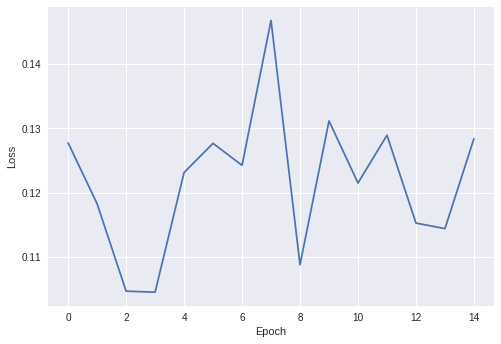

In [147]:
plt.plot(np.arange(0,15), Epoch_Loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Calculating SNR on Validation Data

In [0]:
def SNR(mask, clean, mixed):
    mask = 1 * (mask > 0.5)
    new_clean = mask.T * mixed
    new_clean = librosa.istft(new_clean, win_length = 1024, hop_length = 512)
    n= min(len(clean), len(new_clean))
    
    dB = 10*math.log10((np.sum(clean[:n]**2))/(np.sum((clean[:n] - new_clean[:n])**2)))
    return dB

In [0]:
SNR_Val=[]
for i in range(len(Val_Files[])):
  mask=sess.run(out,feed_dict={x:Val_X[i].reshape(1,longest_seq,513),X_seq_len:Validation_Audio_Len[i]})
  
  s, sr=librosa.load('timit-homework/v/' + Val_Files[i + 2400], sr=None)
  Mixed=librosa.stft(s, n_fft=1024, hop_length=512)
  
  s, sr=librosa.load('timit-homework/v/' + Val_Files[i + 1200], sr=None)
  #Clean=librosa.stft(s, n_fft=1024, hop_length=512)
  
  SNR_Val.append(SNR(mask[0][:Validation_Audio_Len[i],:],s,Mixed))

In [0]:
sns.distplot(SNR_Val, hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 3})

# Reconstructing Test Audio files

In [0]:
Test_Mixed,Test_Audio_Len=[[] for i in range(2)]

for i in range(len(Test_Files)):
    s, sr=librosa.load('timit-homework/te/' + Test_Files[i], sr=None)
    Test_Mixed.append(np.transpose(np.abs(librosa.stft(s, n_fft=1024, hop_length=512))))
    
    Test_Audio_Len.append(len(Test_Mixed[-1]))

In [0]:
Test_X=sequence_padding(Test_Mixed,longest_seq)

In [0]:
Test_Out=sess.run(out,feed_dict={x:Test_X,X_seq_len:Test_Audio_Len})

In [0]:
if os.path.isdir("test_output"):
  for f in os.listdir('test_output'):
      os.remove(os.path.join('test_output', f))
else:
  os.mkdir('test_output')

In [0]:
for i in range(len(Test_Out)):
  s, sr=librosa.load('timit-homework/te/' + Test_Files[i], sr=None)
  noisy=librosa.stft(s, n_fft=1024, hop_length=512)
  mask = 1 * (Test_Out[i] > 0.5)
  new_clean = mask[:Test_Audio_Len[i],:].T * noisy
  new_clean1 = librosa.istft(new_clean, win_length = 1024, hop_length = 512)
  librosa.output.write_wav('test_output/Out_' + Test_Files[i], new_clean1, 16000)

In [179]:
import shutil
shutil.make_archive("output", 'zip', "test_output")

'/content/output.zip'



---



In [0]:
sess.close()
tf.reset_default_graph()

In [0]:
zf = zipfile.ZipFile('output.zip', mode='w')
for f in os.listdir('test_output'):
  zf.write('test_output/'+f,compress_type = zipfile.ZIP_DEFLATED)

In [0]:
from google.colab import files
for f in os.listdir('test_output'):
    files.download('test_output/'+f)